# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 32

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

# import packages
import tarfile
import os
import cv2 as cv
import skimage
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import filters
from scipy import ndimage
from skimage import morphology
import webcolors---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
# import packages
import tarfile
import os
import cv2 as cv
import skimage
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import filters
from scipy import ndimage
from skimage import morphology, io
import webcolors

In [2]:
data_base_path = os.path.join(os.pardir, 'data')
# data_base_path = os.path.join('/home/iapr', 'data')
data_folder = 'lab-01-data'
data_path = os.path.join(data_base_path, data_folder)
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [3]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames) 
images = skimage.io.concatenate_images(ic) # Height*Weight#RGB  480*640*[RGB]
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


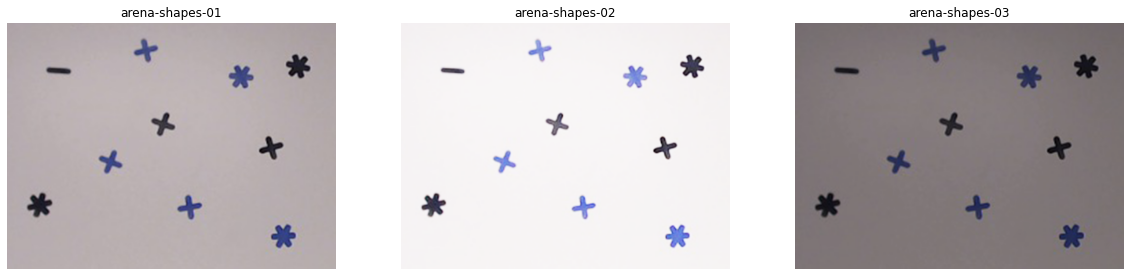

In [4]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(20, 20))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

#### 2.1.1 Histogram

For a grey-scale image, the distribution of grey levels per pixel is an important feature of that image. The histogram of an image depicts the distribution of greyscales in the image and provides a visual representation of how much of the image is occupied by each greyscale class.

However, For colour images, direct histograms can yield less information than grey-scale maps, but a differentiated image channel can be used to obtain a per-channel histogram to aid analysis, which is of great value.

To facilitate the following work, the histogram of the image is first plotted here.

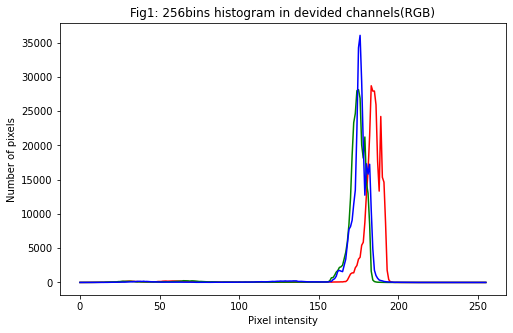

In [5]:
# 3-channel(RGB) histogram of one image
image=images[0]
plt.figure(figsize=(8,5))
color = ('r','g','b')
for i,col in enumerate(color):
    histr = cv.calcHist([image],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlabel('Pixel intensity')
    plt.ylabel('Number of pixels')
    plt.title('Fig1: 256bins histogram in devided channels(RGB)')
plt.show()

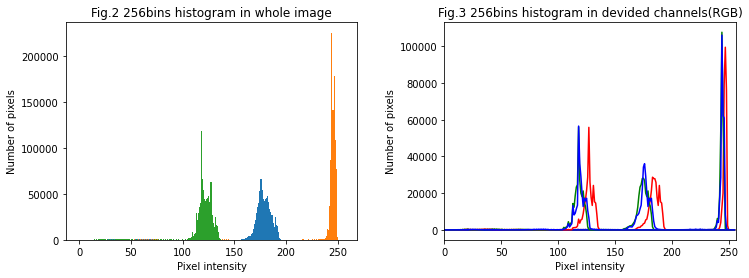

In [6]:
# plot the histogram of the images 
color = ('r','g','b')
# fig = plt.figure(figsize=(20,6))
fig, ax = plt.subplots(1,2,figsize=(12,4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
plt.subplot(1,2,1)
for im in images:
    plt.hist(im.ravel(), 256, [0, 256]) 
    plt.xlabel('Pixel intensity')
    plt.ylabel('Number of pixels')
    plt.title('Fig.2 256bins histogram in whole image')
# plt.show()
plt.subplot(1,2,2)
i=0
for im in images:
    for i,col in enumerate(color):
        # histr = cv.calcHist([im],[i],None,[256],[0,255])
        histr = cv.calcHist([im],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
    plt.xlim([0,256])
    plt.xlabel('Pixel intensity')
    plt.ylabel('Number of pixels')
    plt.title('Fig.3 256bins histogram in devided channels(RGB)')
plt.show()

Each peak in the two subplots represents the distribution of pixels in an independent image data, where the second subplot shows the distribution of pixels in different channels in each image. 

It can be concluded that:
* Fig1:  the RGB channels in one image are relatively concentrated, besides there is linear characteristics shown between the images, meaning image segmentation via RGB channels can be cumbersome but it would be advantageous to use other colour models that can separate the luminance separately. 
* Fig.2, Fig.3: the peaks of the three pictures are different from each other, which also confirms the different lighting conditions of the three pictures as the different lighting conditions cause significant differences in the grey scale of the images. 

So the next step is to perform image space conversion from an RGB model to an HSV or LSB model based on the basic image preprocessing.

*Note: Here we implicitly assume that the image preprocessing operation is beneficial for segmentation, but in the following experiments it is shown that this does not work as we expect.*

### 2.2 Number of shapes of each color (5 pts)

In [7]:
# define a function for ploting multiple images
def plotMultipleImages(nrows, ncols, images, titles, type, cmap=False):
    if type=='typ_img':
        fig = plt.figure(figsize=(10,4))
        # fig.set_tight_layout(True)
        fig.subplots_adjust(hspace=0.4, wspace=0.3)
        for i in range(len(titles)):
            ax = fig.add_subplot(nrows, ncols, i+1)
            if cmap==False:                
                ax.imshow(images[i])
            else:
                ax.imshow(images[i], cmap='gray')
            ax.set_title(titles[i])
            ax.axis('off')
    else:
        fig = plt.figure(figsize=(10,4))
        fig.subplots_adjust(hspace=0.4, wspace=0.3)
        for i in range(len(titles)):
            fig.add_subplot(nrows, ncols, i+1)
            if images[i].max() > 1.01:
                plt.hist(images[i].ravel(), 256, [0, 256])
            else:
                plt.hist(images[i].ravel(), 100, [0, 1]) 
            plt.title(titles[i])
            # ax = plt.gca()
            # ax.axes.xaxis.set_ticks([])
            # ax.axes.yaxis.set_ticks([])
    plt.show()

#### 2.2.1 Pre-processing

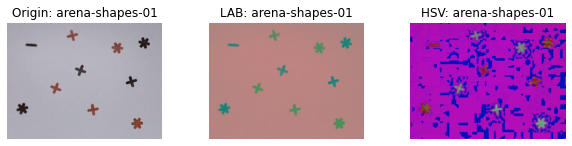

In [8]:
""" Color Model Comparsion """
image = images[0][:,:,::-1]
im_name = im_names[0]

LAB_img = cv.cvtColor(image,cv.COLOR_BGR2LAB)
HSV_img = cv.cvtColor(image,cv.COLOR_BGR2HSV)
imgs=[image,LAB_img,HSV_img]
titles=['Origin: '+im_name,'LAB: '+im_name,'HSV: '+im_name]
plotMultipleImages(1, 3, imgs, titles, 'typ_img')

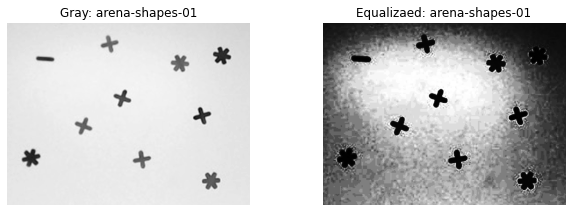

In [9]:
"""
Intensity Equalization and Normalization

A comparison of the three images shows that they differ significantly in terms of luminance, 
and in order to make the algorithm more robust, the normalisation strategy is to be used.  
"""

# Equalization
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
dst = cv.equalizeHist(gray)

imgs = [gray, dst]
titles = ['Gray: '+im_name, 'Equalizaed: '+im_name]
plotMultipleImages(1, 2, imgs, titles,  type='typ_img', cmap='Ture')


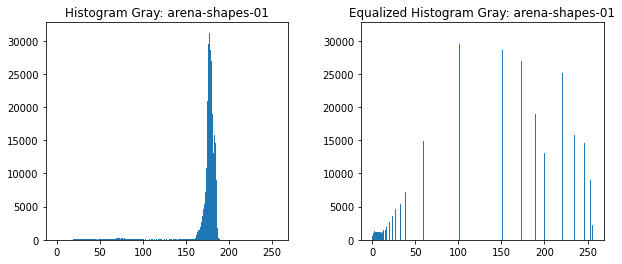

In [10]:
# plot histograms
titles = ['Histogram Gray: '+im_name, 'Equalized Histogram Gray: '+im_name]
plotMultipleImages(1, 2, imgs, titles,  type='typ_hst')

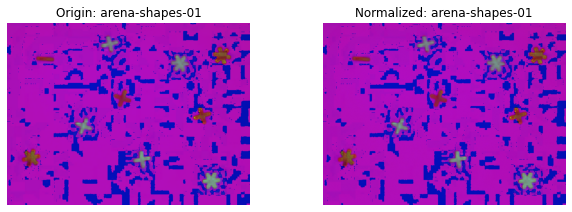

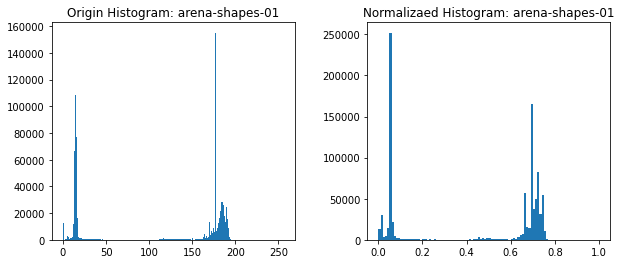

In [11]:
""" Normalizaition """
HSV_img = HSV_img
image_norm_numpy = (HSV_img - np.min(HSV_img)) / (np.max(HSV_img) - np.min(HSV_img))
imgs = [HSV_img, image_norm_numpy]
# plot images
titles = ['Origin: '+im_name, 'Normalized: '+im_name]
plotMultipleImages(1, 2, imgs, titles, type='typ_img')

# plot histograms
titles = ['Origin Histogram: '+im_name, 'Normalizaed Histogram: '+im_name]
plotMultipleImages(1, 2, imgs, titles,  type='typ_hst')

#### 2.2.2 Image Analysis

In [12]:
"""
    Define a class for object and colour analysis in pictures.
        Input: single image H*W*C where c=3
        Output: four lists of data for contours, vertex, col_hsv, col_rgb
"""

class Img_Analysis:

    def analysis(self, frame):
        self.col_rgb = []
        self.col_hsv = []
        self.vertex = []
        self.pixels = []
        
        h, w, ch = frame.shape
        result = np.zeros((h, w, ch), dtype=np.uint8)

        # rgb->binary
        # Perform image greyscaling and threshold segmentation
        gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
        ret, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
        thresh =cv.Canny(binary, 50, 100)
        # plt.imshow()
        # plt.show()
        # Contour detect and visualization
        contours, hierarchy = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        obj_img = np.zeros((h, w, ch), dtype=np.uint8)
        cv.drawContours(obj_img, contours, -1, [255,255,255], thickness=-1)
        plt.figure(figsize=(3,3))
        plt.imshow(obj_img)
        plt.title('Contours of Objects Detected')
        plt.show()
        # Analysis of the detected contours in turn
        for cnt in range(len(contours)):
            obj_img = np.zeros((h, w, ch), dtype=np.uint8)
            cv.drawContours(obj_img, contours, cnt, [255,255,255], thickness=-1)
#             plt.figure(figsize=(3,3))
#             plt.imshow(obj_img)
#             plt.title('Contours of Objects Detected')
#             plt.show()
            gray = cv.cvtColor(obj_img, cv.COLOR_RGB2GRAY)
            ret, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV| cv.THRESH_OTSU)
            values, counts = np.unique(binary, return_counts=True)
#             print(values, counts)
            self.pixels.append(int(counts[0]))
            # Contour approaching
            epsilon = 0.01 * cv.arcLength(contours[cnt], True)
            approx = cv.approxPolyDP(contours[cnt], epsilon, True)

            # Analyse the corners
            corners = len(approx)
            self.vertex.append(corners)
            
            # Obtaining the position of the centre of mass
            mm = cv.moments(contours[cnt])
            cx = int(mm['m10'] / mm['m00'])
            cy = int(mm['m01'] / mm['m00'])

            # Colour analysis
            img_rgb = frame[:,:,::-1]
            color = img_rgb[cy][cx]
            self.col_rgb.append(color)
            img_hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
            color = img_hsv[cy][cx]
            self.col_hsv.append(color)
            
            color_str = "("+ str(color[0]) + ", " + str(color[1]) + "," + str(color[2]) + ")" 
                # Sort objects from smallest to largest by number of vertices
#             if corners < 10 :
# #                 obj_num[Keys[0]] += 1
#                 print('obj_class 1')
#             if corners <= 17 & corners >= 10 :
# #                 obj_num[Keys[1]] += 1
#                 print('obj_class 2')
#             if corners > 17:
# #                 obj_num[Keys[2]] += 1
#                 print('obj_class 3')
            # print("Obj #%2d   Vertexs: %2d,  Color_HSV: %s " % ((cnt+1), corners, color_str))
            
        
            
        return contours, self.vertex, self.col_hsv, self.col_rgb, self.pixels

#### Analysis
1. The visualisation process, due to differences between the CV library and the PLT library in terms of the channels used to read and write the images, therefore the overall tone of the display is somewhat affected, but does not affect the analysis as a whole.
2. By vertex analysis, it can be concluded that there are a total of two distinct divisions within the margin of error, thus indicating that there are **three types of objects**.
3. Given the different luminance of the three images given in the dataset, the **V component** of HSV is filtered out to enhance the robustness of the algorithm to luminance. the **H component** has no obvious pattern, which leaves only the **S component**.

    Using the sample distribution analysis method, based on the colour data of ten object vertices (HSV format), where the distribution of Saturation(S) is roughly in two clusters, it can be roughly assumed that there are **two main types of object colours** in the image.  

#### 2.2.3 Color and Shape Classification

In [13]:
# Shape identification function 
def shape_identify_contours(objs, corners, listOfKeys):  
    # print(objs)
    obj_num= objs
    Keys = listOfKeys   
    
    # Sort objects from smallest to largest by number of vertices
    if corners < 10 :
        obj_num[Keys[0]] += 1
    if corners <= 17 & corners >= 10 :
        obj_num[Keys[1]] += 1
    if corners > 17:
        obj_num[Keys[2]] += 1
    return obj_num

def shape_identify_pixels(objs, pixels, listOfKeys):  
    obj_list = []
    for pixel in pixels:
        if pixel < 500 :
            obj_list.append(1)
        if 500 <= pixel <= 1000:
            obj_list.append(2)
        if pixel > 1000:
            obj_list.append(3)
    obj_set = set(obj_list)
    obj_num={}
    for item in obj_set:
        obj_num.update({item: obj_list.count(item)})
    
    return obj_num

# Color decode function (RGB_TO_TEXT)
def closest_colour(requested_colour):
    min_colours = {}
    # for key, name in webcolors.css3_hex_to_names.items():
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

In [14]:
# Color Homogenisation AND filter
def color_filter(col_hsv, col_rgb, contours):
    
    hsv_mean = np.array((0,0,0))
    hsv_1 = np.array((0,0,0))
    hsv_2 = np.array((0,0,0))
    rgb_1 = np.array((0,0,0))
    rgb_2 = np.array((0,0,0))

    obj = {'col_1':[],'col_2':[]}
    col1_index = []
    col2_index = []

    # Calculate the mean value of ten colours
    for col in col_hsv:
        hsv_mean += col
    hsv_mean = hsv_mean/10

    # Filter the two colours and the corresponding outlines separately
    for i,col in enumerate(col_hsv):
        if col[1]>hsv_mean[1]:
            hsv_1 += col
            rgb_1 += col_rgb[i]
            col1_index.append(i)
            obj['col_1'].append(contours[i])
        else:
            hsv_2 += col
            rgb_2 += col_rgb[i]
            col2_index.append(i)            
            obj['col_2'].append(contours[i])
    color = [hsv_1/5, rgb_1/5, hsv_2/5, rgb_2/5]
    col_obj_1 = [rgb_1/5, col1_index]
    col_obj_2 = [rgb_2/5, col2_index]
    # print(color)
    return col_obj_1, col_obj_2, color, obj

In [15]:
# Final result print
def result_print(vertexs, obj_pixels, class1, class2, color):
    
    col_obj_1 = class1
    col_obj_2 = class2
    
    for i, c in enumerate([col_obj_1, col_obj_2]):
        obj_col = {'Object1': 0, 'Object2': 0, 'Object3': 0}
        # origin in BGR order
        requested_colour = c[0]
        # BGR -> RGB
        new_colour = requested_colour[::-1]
        
        _, closest_name = get_colour_name(new_colour)
        # for j in c[1]:
        #     object_class=shape_identify_contours(obj_col, vertexs[j], listOfKeys = list(obj_col.keys()))
        input_pixels = [obj_pixels[i] for i in c[1]]
        object_class = shape_identify_pixels(obj_col, input_pixels, listOfKeys = list(obj_col.keys()))
        print("Color: {} (mean: {})".format(closest_name.upper(), [round(i) for i in new_colour]))
        print(object_class)


arena-shapes-01


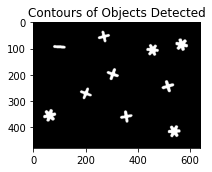

Color: DARKSLATEBLUE (mean: [58, 68, 134])
{2: 3, 3: 2}
Color: DARKSLATEGRAY (mean: [38, 36, 47])
{1: 1, 2: 2, 3: 2}
Vertexs: [20, 16, 22, 16, 16, 16, 8, 18, 20, 16]
Pixels: [1318, 866, 1386, 831, 951, 891, 484, 1226, 1362, 805]

arena-shapes-02


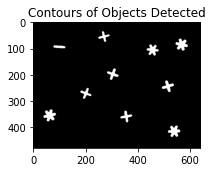

Color: CORNFLOWERBLUE (mean: [114, 134, 223])
{2: 3, 3: 2}
Color: DARKSLATEGRAY (mean: [75, 72, 92])
{1: 1, 2: 2, 3: 2}
Vertexs: [21, 17, 23, 17, 16, 17, 8, 21, 21, 19]
Pixels: [1182, 730, 1237, 677, 857, 775, 403, 1047, 1242, 625]

arena-shapes-03


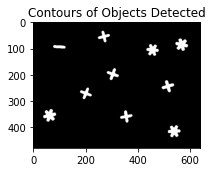

Color: MIDNIGHTBLUE (mean: [38, 44, 87])
{2: 3, 3: 2}
Color: BLACK (mean: [25, 24, 30])
{1: 1, 2: 2, 3: 2}
Vertexs: [20, 17, 22, 16, 17, 16, 8, 21, 21, 17]
Pixels: [1334, 887, 1411, 857, 966, 901, 497, 1253, 1384, 827]


In [16]:
# Implement image analyze for the three images
for i, img in enumerate(images):
    print('\n'+im_names[i])
    src = img
    image_analyze = Img_Analysis()
    contours, vertexs, col_hsv, col_rgb, obj_pixels = image_analyze.analysis(src)
    col_obj_1, col_obj_2, colors, objs = color_filter(col_hsv, col_rgb, contours)
    result_print(vertexs, obj_pixels, col_obj_1, col_obj_2, colors)
#     print(obj_pixels)
    print("Vertexs: {}\nPixels: {}".format(vertexs, obj_pixels))

In [17]:
col_obj_2[1]

[2, 4, 5, 6, 8]

#### Conclusion

* arena-shapes-01

| -               | Color1                        | Color2                             |
| :-------------- | :---------------------------- | :--------------------------------- |
| Name (mean RGB) | DARKSLATEBLUE ([58, 68, 134]) | DARKSLATEGRAY (mean: [38, 36, 47]) |
| Shape1 (-)      | 0                             | 1                                  |
| Shape2 (+)      | 3                             | 2                                  |
| Shape3 (*)      | 2                             | 2                                  |


* arena-shapes-02

| -               | Color1                        | Color2                             |
| :-------------- | :---------------------------- | :--------------------------------- |
| Name (mean RGB) | CORNFLOWERBLUE ([113, 133, 223]) | DARKSLATEGRAY ([75, 72, 92]) |
| Shape1 (-)      | 0                             | 1                                  |
| Shape2 (+)      | 3                             | 2                                  |
| Shape3 (*)      | 2                             | 2                                  |
        
* arena-shapes-03

| -               | Color1                        | Color2                             |
| :-------------- | :---------------------------- | :--------------------------------- |
| Name (mean RGB) | MIDNIGHTBLUE ([38, 44, 87]) | BLACK ([25, 24, 30]) |
| Shape1 (-)      | 0                             | 1                                  |
| Shape2 (+)      | 3                             | 2                                  |
| Shape3 (*)      | 2                             | 2                                  |

NOTE: 

    1. Objects are sorted from smallest to largest by number of vertices

    2. Color RGB to name using package: webcolors(https://webcolors.readthedocs.io/en/1.11.1/)

### 2.3 Total area (in pixels) of each color (5 pts)

**Some comments of the algorithm... (to be updated)**


arena-shapes-01


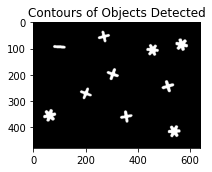

Total area (in pixels) of Color1 is: 5046
Total area (in pixels) of Color2 is: 5074


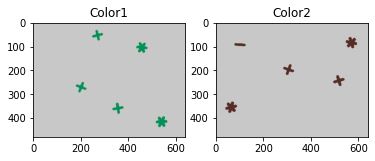


arena-shapes-02


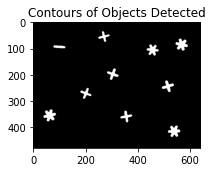

Total area (in pixels) of Color1 is: 4261
Total area (in pixels) of Color2 is: 4514


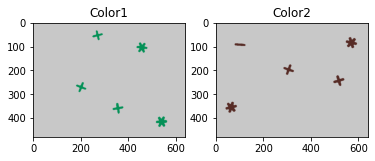


arena-shapes-03


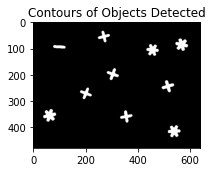

Total area (in pixels) of Color1 is: 5158
Total area (in pixels) of Color2 is: 5159


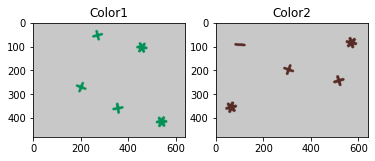

In [18]:
for i, img in enumerate(images):
    print('\n'+im_names[i])
    src = img
    image_analyze = Img_Analysis()
    contours, vertexs, col_hsv, col_rgb, _ = image_analyze.analysis(src)
    col_obj_1, col_obj_2, col, objs = color_filter(col_hsv, col_rgb, contours)
    # # result_print(vertexs, col_obj_1, col_obj_2, col)    
    h, w, ch = img.shape
    titles = ['Color1', 'Color2']
    # Pixels Count and visualization
    for i,cnt in enumerate([objs['col_1'], objs['col_2']]):
        obj_img = np.ones((h, w, ch), dtype=np.uint8)*200
        # cv.drawContours(obj_img, cnt, -1, (), thickness=-1)
        cv.drawContours(obj_img, cnt, -1, (colors[i][0].item(),colors[i][1].item(),colors[i][2].item()), thickness=-1)
        gray = cv.cvtColor(obj_img, cv.COLOR_RGB2GRAY)
        ret, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV| cv.THRESH_OTSU)
        values, counts = np.unique(binary, return_counts=True)
        print('Total area (in pixels) of {} is: {}'.format(titles[i], counts[1]))

        plt.subplot(1,2,i+1)
        plt.title(titles[i])
        plt.imshow(obj_img)
    plt.show()

#### Result and Analysis
* **Result**

| Images / Pixel number | Color1 | Color2 |
| :-------------------- | :----- | :----- |
| arena-shapes-01       | 5046   | 5074   |
| arena-shapes-02       | 4261   | 4514   |
| arena-shapes-03       | 5158   | 5159   |
    
* **Analysis**

### Reference

1. webcolors: https://webcolors.readthedocs.io/en/1.11.1/

In [19]:
colors[i][0].item(),colors[i][1].item(),colors[i][2].item()

(87.2, 44.2, 37.6)